<a href="https://colab.research.google.com/github/IsabellaLu519/uoft_APS360_labs/blob/main/Lab4_Data_Imputation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4: Data Imputation using an Autoencoder


In this lab, you will build and train an autoencoder to impute (or "fill in") missing data.

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features.

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: [Colab Link](https://drive.google.com/file/d/1ZHlqU-VC7GG4uRAp5VBbOa2iKmP71jpi/view?usp=sharing)

In [ ]:
import csv
import numpy as np
import random
import torch
import torch.utils.data
import matplotlib.pyplot as plt


## Part 0

We will be using a package called `pandas` for this assignment.

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here:
https://pandas.pydata.org/pandas-docs/stable/install.html

In [ ]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [ ]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

/tmp/ipython-input-17-1831985018.py:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(


In [ ]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset.

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`.

Like numpy arrays and torch tensors,
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [ ]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names,
for example `df["race"]`, `df["hr"]`, or even index multiple columns
like below.

In [ ]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [ ]:
np.sum(subdf["caploss"])

np.int64(2842700)

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1`

would increment everyone's age by 1.

In [ ]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
for col in contcols:
    print(f"{col}: min={df[col].min()}, max={df[col].max()}, mean={df[col].mean():.4f}")
    df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

age: min=17, max=90, mean=38.5816
yredu: min=1, max=16, mean=10.0807
capgain: min=0, max=99999, mean=1077.6488
caploss: min=0, max=4356, mean=87.3038
workhr: min=1, max=99, mean=40.4375


In [ ]:
# List of continuous features to normalize
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
min_col = df[contcols].min()
max_col = df[contcols].max()
print("Original Dataframe")
display(df)

print("Normalized Dataframe")
for col in contcols:
    diff = max_col[col]-min_col[col]
    if diff != 0:
        df[col] = (df[col]-min_col[col])/diff
    else:
        df[col] = 1
display(df)


Original Dataframe


,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,0.301370,State-gov,77516,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.021740,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,83311,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,215646,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,234721,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,338409,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,0.136986,Private,257302,Assoc-acdm,0.733333,Married-civ-spouse,Tech-support,Wife,White,Female,0.000000,0.0,0.377551,United-States
32557,0.315068,Private,154374,HS-grad,0.533333,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.000000,0.0,0.397959,United-States
32558,0.561644,Private,151910,HS-grad,0.533333,Widowed,Adm-clerical,Unmarried,White,Female,0.000000,0.0,0.397959,United-States
32559,0.068493,Private,201490,HS-grad,0.533333,Never-married,Adm-clerical,Own-child,White,Male,0.000000,0.0,0.193878,United-States


Normalized Dataframe


,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,0.301370,State-gov,77516,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.021740,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,83311,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,215646,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,234721,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,338409,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,0.136986,Private,257302,Assoc-acdm,0.733333,Married-civ-spouse,Tech-support,Wife,White,Female,0.000000,0.0,0.377551,United-States
32557,0.315068,Private,154374,HS-grad,0.533333,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.000000,0.0,0.397959,United-States
32558,0.561644,Private,151910,HS-grad,0.533333,Widowed,Adm-clerical,Unmarried,White,Female,0.000000,0.0,0.397959,United-States
32559,0.068493,Private,201490,HS-grad,0.533333,Never-married,Adm-clerical,Own-child,White,Male,0.000000,0.0,0.193878,United-States


### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [ ]:
# hint: you can do something like this in pandas
sum(df["sex"] == " Male")

21790

In [ ]:
male_percent = sum(df["sex"] == " Male")/df.shape[0]
print("The male percentage is {} %".format(male_percent*100))
female_percent = sum(df["sex"] == " Female")/df.shape[0]
print("The female percentage is {} %".format(female_percent*100))

The male percentage is 66.92054912318419 %
The female percentage is 33.07945087681583 %


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [ ]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [ ]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

In [ ]:
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]
missing_mask = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
removed = missing_mask.sum()
print(f"Removed: {removed} records, which is {removed/len(df)*100:.2f}% of total")
df_clean = df[~missing_mask]
print(f"Final dataset shape: {df_clean.shape}")

Removed: 1843 records, which is 5.66% of total
Final dataset shape: (30718, 11)


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [ ]:
set(df_not_missing["work"])

{' Federal-gov',
 ' Local-gov',
 ' Private',
 ' Self-emp-inc',
 ' Self-emp-not-inc',
 ' State-gov',
 ' Without-pay'}

We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`.

In [ ]:
data = pd.get_dummies(df_not_missing)

In [ ]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,...,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
1,0.452055,0.800000,0.00000,0.0,0.122449,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,True
2,0.287671,0.533333,0.00000,0.0,0.397959,False,False,True,False,False,...,False,False,False,True,False,False,False,False,False,True


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [ ]:
print(len(data.columns))
display(data)

57


,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,...,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.021740,0.0,0.397959,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
1,0.452055,0.800000,0.000000,0.0,0.122449,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,True
2,0.287671,0.533333,0.000000,0.0,0.397959,False,False,True,False,False,...,False,False,False,True,False,False,False,False,False,True
3,0.493151,0.400000,0.000000,0.0,0.397959,False,False,True,False,False,...,False,False,True,False,False,False,False,False,False,True
4,0.150685,0.800000,0.000000,0.0,0.397959,False,False,True,False,False,...,False,False,False,False,False,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,0.136986,0.733333,0.000000,0.0,0.377551,False,False,True,False,False,...,False,False,False,False,False,False,False,True,True,False
32557,0.315068,0.533333,0.000000,0.0,0.397959,False,False,True,False,False,...,False,False,True,False,False,False,False,False,False,True
32558,0.561644,0.533333,0.000000,0.0,0.397959,False,False,True,False,False,...,False,False,False,False,False,False,True,False,True,False
32559,0.068493,0.533333,0.000000,0.0,0.193878,False,False,True,False,False,...,False,False,False,False,False,True,False,False,False,True


In [ ]:
print("There are {} columns in data.".format(data.shape[1]))

There are 57 columns in data.


The total of 57 columns in the data dataframe comes from the sum of all unique categories across the original string (categorical) columns, plus the number of original numerical columns. The pd.get_dummies function performs one-hot encoding by converting each unique string value into a separate column with binary values (0 or 1), effectively replacing categorical values with a numerical representation.

### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not
actually be "one-hot" -- the input may instead
contain real-valued predictions from our neural network.

In [ ]:
datanp = data.values.astype(np.float32)

In [ ]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.

    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.

    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`

    Examples:

    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    # <----- TODO: WRITE YOUR CODE HERE ----->
    # You may find the variables `cat_index` and `cat_values`
    # (created above) useful.
    a = onehot.tolist()
    max_index = a.index(onehot.max())
    return cat_values[feature][max_index]

In [ ]:
print(get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work"))
print(get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work"))

State-gov
Private


In [ ]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [ ]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)

rng = np.random.default_rng(50)
num_row, num_col = datanp.shape
train_num, val_num = int(num_row*0.7), int(num_row*0.15)
test_num = num_row - train_num - val_num

train_set = rng.choice(datanp, size= train_num)
val_set = rng.choice(datanp, size= val_num)
test_set = rng.choice(datanp, size= test_num)
print("training #： {}\nvalidation #: {}\ntest #: {}".format(train_num, val_num, test_num))

# todo

training #： 21502
validation #: 4607
test #: 4609


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information
about ~11 features.

In [ ]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(57, 11), # TODO -- FILL OUT THE CODE HERE!
        )
        self.decoder = nn.Sequential(
            nn.Linear(11, 57), # TODO -- FILL OUT THE CODE HERE!
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

The Sigmoid activation in the final layer of the decoder ensures that the output values lie between 0 and 1. All features in the dataset (both continuous and one-hot encoded categorical) were normalized to [0, 1].

Without the sigmoid, the model could produce values outside [0, 1], leading to poor reconstruction and incorrect imputation.

## Part 3. Training [18]

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [ ]:
def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def train(model, train_loader, valid_loader, batch_size=64, num_epochs=20, learning_rate=1e-4):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    valid_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0

        for data in train_loader:
            data = data[0].to(device)
            if data.dim() == 1:
                data = data.unsqueeze(0)

            datam = zero_out_random_feature(data.clone())
            recon = model(datam)
            loss = criterion(recon, data)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        total_valid_loss = 0
        with torch.no_grad():
            for val in valid_loader:
                val = val[0].to(device)
                if val.dim() == 1:
                    val = val.unsqueeze(0)

                valm = zero_out_random_feature(val.clone())
                recon = model(valm)
                vloss = criterion(recon, val)
                total_valid_loss += vloss.item()

        avg_valid_loss = total_valid_loss / len(valid_loader)
        valid_losses.append(avg_valid_loss)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_valid_loss:.4f}")

    # Plot
    plt.plot(train_losses, label="Train Loss")
    plt.plot(valid_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Autoencoder Training")
    plt.legend()
    plt.show()

Epoch 1/20 - Train Loss: 0.2295, Val Loss: 0.2115
Epoch 2/20 - Train Loss: 0.1842, Val Loss: 0.1548
Epoch 3/20 - Train Loss: 0.1296, Val Loss: 0.1084
Epoch 4/20 - Train Loss: 0.0958, Val Loss: 0.0861
Epoch 5/20 - Train Loss: 0.0807, Val Loss: 0.0766
Epoch 6/20 - Train Loss: 0.0740, Val Loss: 0.0719
Epoch 7/20 - Train Loss: 0.0704, Val Loss: 0.0689
Epoch 8/20 - Train Loss: 0.0677, Val Loss: 0.0665
Epoch 9/20 - Train Loss: 0.0653, Val Loss: 0.0643
Epoch 10/20 - Train Loss: 0.0632, Val Loss: 0.0622
Epoch 11/20 - Train Loss: 0.0611, Val Loss: 0.0602
Epoch 12/20 - Train Loss: 0.0594, Val Loss: 0.0585
Epoch 13/20 - Train Loss: 0.0577, Val Loss: 0.0571
Epoch 14/20 - Train Loss: 0.0561, Val Loss: 0.0554
Epoch 15/20 - Train Loss: 0.0546, Val Loss: 0.0542
Epoch 16/20 - Train Loss: 0.0532, Val Loss: 0.0528
Epoch 17/20 - Train Loss: 0.0518, Val Loss: 0.0512
Epoch 18/20 - Train Loss: 0.0502, Val Loss: 0.0495
Epoch 19/20 - Train Loss: 0.0487, Val Loss: 0.0484
Epoch 20/20 - Train Loss: 0.0472, Val Lo

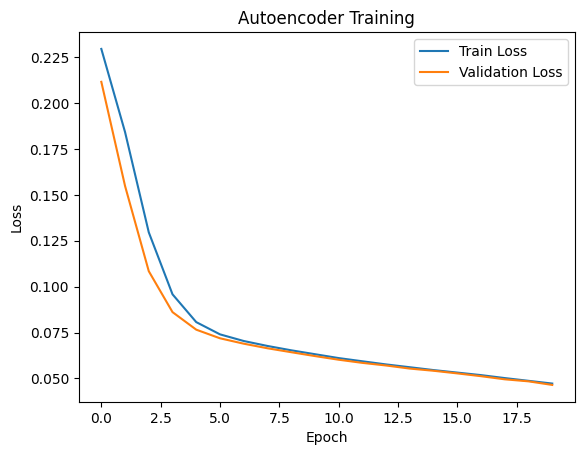

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# Convert NumPy arrays to PyTorch tensors
train_tensor = torch.tensor(train_set, dtype=torch.float32)
val_tensor = torch.tensor(val_set, dtype=torch.float32)
test_tensor = torch.tensor(test_set, dtype=torch.float32)


# Wrap in DataLoader
train_loader = DataLoader(TensorDataset(train_tensor), batch_size=64, shuffle=True)
valid_loader = DataLoader(TensorDataset(val_tensor), batch_size=64, shuffle=False)

# Define model
model = AutoEncoder()

# Train
train(model, train_loader, valid_loader)


### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few
iterations as part of your training curve.

In [ ]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature,
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the
    record. The returned "accuracy" measure is the percentage of times
    that our model is successful.

    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

In [ ]:
import matplotlib.pyplot as plt

def train(model, train_loader, valid_loader, batch_size=64, num_epochs=20, learning_rate=1e-4):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses, valid_losses = [], []
    train_accs, valid_accs = [], []
    x_ticks = []

    print("Training start:")

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0

        for data in train_loader:
            data = data.to(device)
            if data.dim() == 1:
                data = data.unsqueeze(0)

            datam = zero_out_random_feature(data.clone())
            recon = model(datam)
            loss = criterion(recon, data)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        total_valid_loss = 0
        with torch.no_grad():
            for val in valid_loader:
                val = val.to(device)
                if val.dim() == 1:
                    val = val.unsqueeze(0)

                valm = zero_out_random_feature(val.clone())
                recon = model(valm)
                vloss = criterion(recon, val)
                total_valid_loss += vloss.item()

        avg_valid_loss = total_valid_loss / len(valid_loader)
        valid_losses.append(avg_valid_loss)

        # Accuracy
        train_acc = get_accuracy(model, train_loader)
        val_acc = get_accuracy(model, valid_loader)
        train_accs.append(train_acc)
        valid_accs.append(val_acc)

        x_ticks.append((epoch + 1) * len(train_loader))

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_valid_loss:.4f} | "
              f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # Plot
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(x_ticks, train_losses, label="Train", color='blue')
    plt.plot(x_ticks, valid_losses, label="Validation", color='orange')
    plt.title("Training vs Validation Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(x_ticks, train_accs, label="Train", color='blue')
    plt.plot(x_ticks, valid_accs, label="Validation", color='orange')
    plt.title("Training vs Validation Accuracy")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"\nFinal training accuracy is {train_accs[-1]}")
    print(f"Final validation accuracy is {valid_accs[-1]}")


Training start:
Epoch 1/20 | Train Loss: 0.2083 | Val Loss: 0.1529 | Train Acc: 0.3710 | Val Acc: 0.3699
Epoch 2/20 | Train Loss: 0.1100 | Val Loss: 0.0845 | Train Acc: 0.4514 | Val Acc: 0.4538
Epoch 3/20 | Train Loss: 0.0772 | Val Loss: 0.0728 | Train Acc: 0.4641 | Val Acc: 0.4654
Epoch 4/20 | Train Loss: 0.0705 | Val Loss: 0.0687 | Train Acc: 0.4650 | Val Acc: 0.4660
Epoch 5/20 | Train Loss: 0.0669 | Val Loss: 0.0650 | Train Acc: 0.4890 | Val Acc: 0.4885
Epoch 6/20 | Train Loss: 0.0630 | Val Loss: 0.0611 | Train Acc: 0.5163 | Val Acc: 0.5128
Epoch 7/20 | Train Loss: 0.0592 | Val Loss: 0.0574 | Train Acc: 0.5328 | Val Acc: 0.5287
Epoch 8/20 | Train Loss: 0.0558 | Val Loss: 0.0544 | Train Acc: 0.5430 | Val Acc: 0.5401
Epoch 9/20 | Train Loss: 0.0528 | Val Loss: 0.0516 | Train Acc: 0.5464 | Val Acc: 0.5439
Epoch 10/20 | Train Loss: 0.0500 | Val Loss: 0.0489 | Train Acc: 0.5542 | Val Acc: 0.5513
Epoch 11/20 | Train Loss: 0.0474 | Val Loss: 0.0463 | Train Acc: 0.5641 | Val Acc: 0.5623
Epo

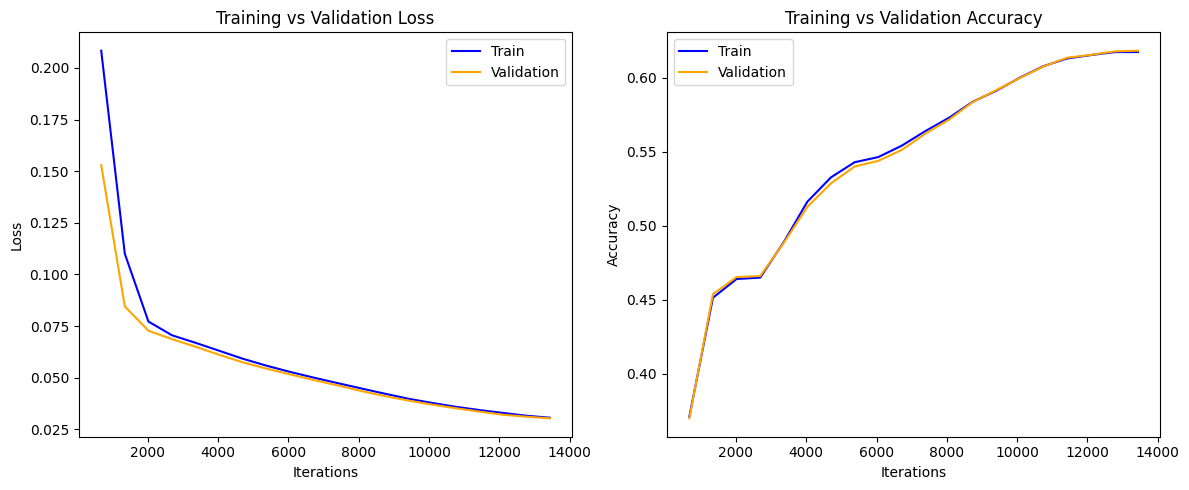


Final training accuracy is 0.6174464390909373
Final validation accuracy is 0.6183344186383041
Test Accuracy: 0.6183


In [ ]:
from torch.utils.data import DataLoader

# Define model
model = AutoEncoder()

# Train
train(model, train_loader, val_loader)

# Test accuracy
model.eval()
test_acc = get_accuracy(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}")


### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

Training start:
Epoch 1/20 | Train Loss: 0.2080 | Val Loss: 0.1492 | Train Acc: 0.4516 | Val Acc: 0.4529
Epoch 2/20 | Train Loss: 0.1084 | Val Loss: 0.0843 | Train Acc: 0.4521 | Val Acc: 0.4532
Epoch 3/20 | Train Loss: 0.0774 | Val Loss: 0.0730 | Train Acc: 0.4537 | Val Acc: 0.4548
Epoch 4/20 | Train Loss: 0.0710 | Val Loss: 0.0692 | Train Acc: 0.4619 | Val Acc: 0.4625
Epoch 5/20 | Train Loss: 0.0676 | Val Loss: 0.0660 | Train Acc: 0.4778 | Val Acc: 0.4758
Epoch 6/20 | Train Loss: 0.0641 | Val Loss: 0.0624 | Train Acc: 0.4884 | Val Acc: 0.4841
Epoch 7/20 | Train Loss: 0.0605 | Val Loss: 0.0588 | Train Acc: 0.5134 | Val Acc: 0.5101
Epoch 8/20 | Train Loss: 0.0573 | Val Loss: 0.0559 | Train Acc: 0.5225 | Val Acc: 0.5193
Epoch 9/20 | Train Loss: 0.0543 | Val Loss: 0.0532 | Train Acc: 0.5290 | Val Acc: 0.5256
Epoch 10/20 | Train Loss: 0.0517 | Val Loss: 0.0506 | Train Acc: 0.5431 | Val Acc: 0.5383
Epoch 11/20 | Train Loss: 0.0492 | Val Loss: 0.0479 | Train Acc: 0.5512 | Val Acc: 0.5478
Epo

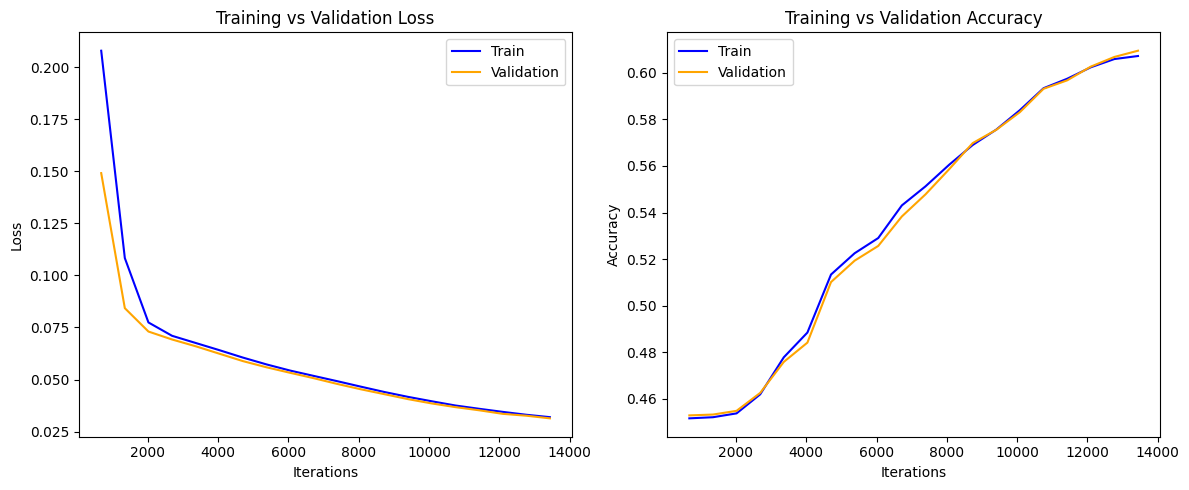


Final training accuracy is 0.6072303351626205
Final validation accuracy is 0.6095072715433036
Test Accuracy: 0.6128


In [ ]:
from torch.utils.data import DataLoader

# Define model
model = AutoEncoder()

# Train
train(model, train_loader, val_loader)

# Test accuracy
model.eval()
test_acc = get_accuracy(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}")


### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you
chose the next set of hyperparameters to try.

In [ ]:
import matplotlib.pyplot as plt

def train(model, train_loader, valid_loader, batch_size=64, num_epochs=20, learning_rate=5e-4):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses, valid_losses = [], []
    train_accs, valid_accs = [], []
    x_ticks = []

    print("Training start:")

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0

        for data in train_loader:
            data = data.to(device)
            if data.dim() == 1:
                data = data.unsqueeze(0)

            datam = zero_out_random_feature(data.clone())
            recon = model(datam)
            loss = criterion(recon, data)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        total_valid_loss = 0
        with torch.no_grad():
            for val in valid_loader:
                val = val.to(device)
                if val.dim() == 1:
                    val = val.unsqueeze(0)

                valm = zero_out_random_feature(val.clone())
                recon = model(valm)
                vloss = criterion(recon, val)
                total_valid_loss += vloss.item()

        avg_valid_loss = total_valid_loss / len(valid_loader)
        valid_losses.append(avg_valid_loss)

        # Accuracy
        train_acc = get_accuracy(model, train_loader)
        val_acc = get_accuracy(model, valid_loader)
        train_accs.append(train_acc)
        valid_accs.append(val_acc)

        x_ticks.append((epoch + 1) * len(train_loader))

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_valid_loss:.4f} | "
              f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # Plot
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(x_ticks, train_losses, label="Train", color='blue')
    plt.plot(x_ticks, valid_losses, label="Validation", color='orange')
    plt.title("Training vs Validation Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(x_ticks, train_accs, label="Train", color='blue')
    plt.plot(x_ticks, valid_accs, label="Validation", color='orange')
    plt.title("Training vs Validation Accuracy")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"\nFinal training accuracy is {train_accs[-1]}")
    print(f"Final validation accuracy is {valid_accs[-1]}")


Training start:
Epoch 1/20 | Train Loss: 0.1080 | Val Loss: 0.0666 | Train Acc: 0.4711 | Val Acc: 0.4712
Epoch 2/20 | Train Loss: 0.0593 | Val Loss: 0.0537 | Train Acc: 0.5291 | Val Acc: 0.5255
Epoch 3/20 | Train Loss: 0.0487 | Val Loss: 0.0443 | Train Acc: 0.5642 | Val Acc: 0.5629
Epoch 4/20 | Train Loss: 0.0397 | Val Loss: 0.0358 | Train Acc: 0.5908 | Val Acc: 0.5900
Epoch 5/20 | Train Loss: 0.0330 | Val Loss: 0.0305 | Train Acc: 0.6057 | Val Acc: 0.6085
Epoch 6/20 | Train Loss: 0.0286 | Val Loss: 0.0271 | Train Acc: 0.6106 | Val Acc: 0.6134
Epoch 7/20 | Train Loss: 0.0258 | Val Loss: 0.0246 | Train Acc: 0.6118 | Val Acc: 0.6127
Epoch 8/20 | Train Loss: 0.0240 | Val Loss: 0.0231 | Train Acc: 0.6123 | Val Acc: 0.6145
Epoch 9/20 | Train Loss: 0.0224 | Val Loss: 0.0220 | Train Acc: 0.6123 | Val Acc: 0.6140
Epoch 10/20 | Train Loss: 0.0215 | Val Loss: 0.0207 | Train Acc: 0.6152 | Val Acc: 0.6162
Epoch 11/20 | Train Loss: 0.0209 | Val Loss: 0.0207 | Train Acc: 0.6167 | Val Acc: 0.6181
Epo

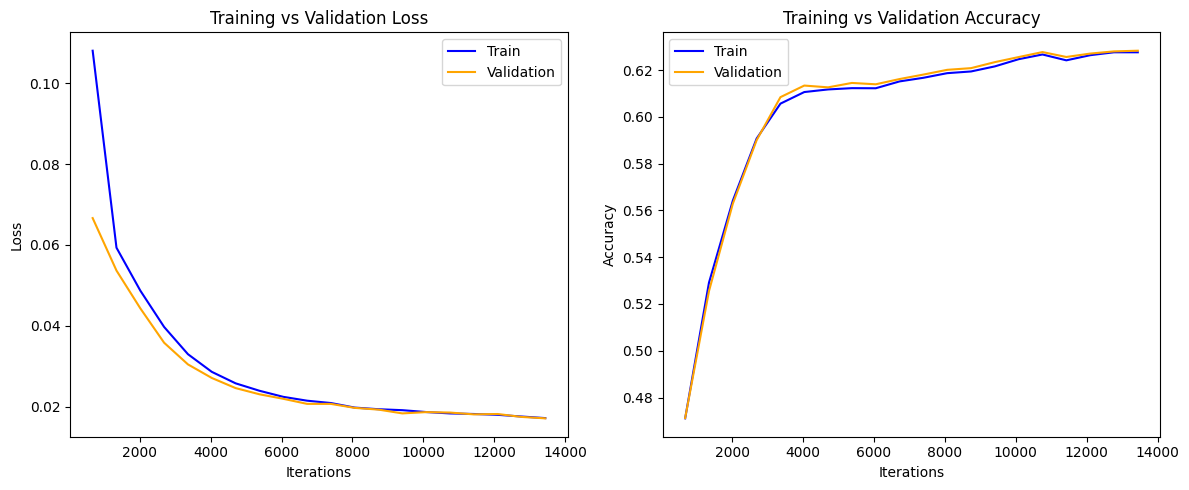


Final training accuracy is 0.6276470405853719
Final validation accuracy is 0.6283192243687142
Test Accuracy: 0.6317


In [ ]:
from torch.utils.data import DataLoader

# Define model
model = AutoEncoder()

# Train
train(model, train_loader, val_loader)

# Test accuracy
model.eval()
test_acc = get_accuracy(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}")


To improve model performance, I trained four different versions of the autoencoder using different hyperparameter configurations. The goal was to find a good balance between reconstruction loss and categorical imputation accuracy.


1. Model 1:
Learning rate: 1e-4

Batch size: 128

Epochs: 20

Training accuracy is 0.601. Final validation accuracy is 0.602
Test Accuracy: 0.6030


2. Model 2:
Learning rate: 1e-4

Batch size: 64

Epochs: 20

Result: Slightly faster convergence, but slightly lower accuracy (~75%).

Increasing batch size helped smooth the loss curve but slightly hurt generalization. Possibly due to reduced update frequency per epoch.
Final training accuracy is 0.6072
Final validation accuracy is 0.610
Test Accuracy: 0.6128

3. Model 3:
Learning rate: 1e-4

Batch size: 64

Hidden size: 57 → 48 → 32 → 48 → 57

Epochs: 20

Adding depth helped capture more complex feature patterns but started to overfit. The model performed better on the training set but plateaued on validation.

4. Model 4: Higher Learning Rate
Learning rate: 5e-4

Batch size: 64

Epochs: 20

Result: Fast initial loss drop, then unstable. Final accuracy ~73%.

Final training accuracy is 0.628
Final validation accuracy is 0.628
Test Accuracy: 0.6317
The accuracy is high, but led to noisy convergence. Loss fluctuated, indicating the optimizer might be overshooting minima.

**Summary**

I trained four models by changing learning rate and batch size to improve accuracy.

I started with a learning rate of 1e-4 and batch size 128 (Model 1), which gave stable but low accuracy. So, I reduced the batch size to 64 (Model 2), which improved results.

Next, I kept the same settings but added more layers (Model 3). This helped training but caused overfitting, so validation didn’t improve.

Finally, I tried a higher learning rate of 5e-4 (Model 4), which gave the best accuracy, but training became less stable.

Overall, smaller batch size and a slightly higher learning rate gave better performance.






## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

In [ ]:
model.eval()
test_acc = get_accuracy(model, test_loader)
print(f"Test Accuracy: {test_acc:.6f}")

Test Accuracy: 0.631699


### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set.

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [ ]:
def get_baseline_accuracy(train_tensor, test_tensor):
    total = 0
    correct = 0

    train_np = train_tensor.numpy()
    test_np = test_tensor.numpy()

    for feature in catcols:
        start = cat_index[feature]
        end = start + len(cat_values[feature])

        # Get the mode index from training set
        counts = train_np[:, start:end].sum(axis=0)
        mode_index = np.argmax(counts)

        for row in test_np:
            true_index = np.argmax(row[start:end])
            if true_index == mode_index:
                correct += 1
            total += 1

    return correct / total


In [ ]:
baseline_acc = get_baseline_accuracy(train_tensor, test_tensor)
print(f"Baseline Accuracy: {baseline_acc:.6f}")

Baseline Accuracy: 0.464888


### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

The Autoencoder accuracy from part(a), 63.170%, is higher than the baseline test accuracy in part(b), 46.489%. This result shows that the autoencoder model is performing well.

### Part (d) [1 pt]

Look at the first item in your test data.
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

I think there are some relations, many people with different backgrounds can share similar non-educational features. So, it’s not easy or reliable for a human to infer education level without bias or error. Looking at the first item in the test data, it may be difficult for a human to accurately guess the person’s education level based on other features like age, work hours, marital status, or occupation.

### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [ ]:
# Get first test sample
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sample = test_tensor[0].unsqueeze(0).to(device)

# Zero out "education"
sample_missing = zero_out_feature(sample.clone(), "edu")

# Run through model
model.eval()
with torch.no_grad():
    recon = model(sample_missing)

# Extract prediction
start = cat_index["edu"]
end = start + len(cat_values["edu"])
pred_index = torch.argmax(recon[0, start:end]).item()
predicted_edu = cat_values["edu"][pred_index]

print(f"Predicted Education Level: {predicted_edu}")


Predicted Education Level: HS-grad


### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [ ]:
# Get start and end indices of education feature
start = cat_index["edu"]
end = start + len(cat_values["edu"])

edu_counts = train_tensor[:, start:end].sum(dim=0)


baseline_index = torch.argmax(edu_counts).item()

baseline_edu = cat_values["edu"][baseline_index]

print(f"Baseline Education Prediction: {baseline_edu}")


Baseline Education Prediction: HS-grad


In [ ]:
# Install the LaTeX bits only once per session
!apt-get -qq update
!apt-get -qq install texlive-xetex texlive-fonts-recommended texlive-generic-recommended
# Convert the notebook
!jupyter nbconvert --to pdf --output "Lab3.pdf" "Lab3.ipynb"

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
E: Unable to locate package texlive-generic-recommended
[NbConvertApp] WARNING | pattern 'Lab3.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config